In [1]:
from google.colab import files

uploaded = files.upload()

Saving Netflix Inc. (NFLX) Stock Price 2002-2025.csv to Netflix Inc. (NFLX) Stock Price 2002-2025.csv


In [2]:
import pandas as pd

df = pd.read_csv('Netflix Inc. (NFLX) Stock Price 2002-2025.csv')

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,"Feb 25, 2025",989.4,994.4,955,977.24,977.24,"4,733,000"
1,"Feb 24, 2025","1,008.00","1,015.17",984.48,988.47,988.47,"4,426,200"
2,"Feb 21, 2025","1,029.42","1,032.38",999.39,"1,003.15","1,003.15","3,738,700"
3,"Feb 20, 2025","1,042.00","1,045.00","1,015.59","1,024.54","1,024.54","3,111,800"
4,"Feb 19, 2025","1,035.18","1,045.00","1,024.51","1,043.33","1,043.33","2,600,000"


In [ ]:
df['Date'] = pd.to_datetime(df['Date'])

df = df.sort_values('Date').reset_index(drop=True)
data = df[['Close']].copy()


print(data.head())
print(data.columns)

print(df.dtypes)
print(df['Date'].head())

  Close
0   1.2
1  1.21
2  1.16
3   1.1
4  1.07
Index(['Close'], dtype='object')
Date         datetime64[ns]
Open                 object
High                 object
Low                  object
Close                object
Adj Close            object
Volume               object
dtype: object
0   2002-05-23
1   2002-05-24
2   2002-05-28
3   2002-05-29
4   2002-05-30
Name: Date, dtype: datetime64[ns]


In [ ]:

df['Close'] = pd.to_numeric(df['Close'], errors='coerce')
df = df.dropna(subset=['Close'])
print(df['Close'].isna().sum())  # should be 0

0


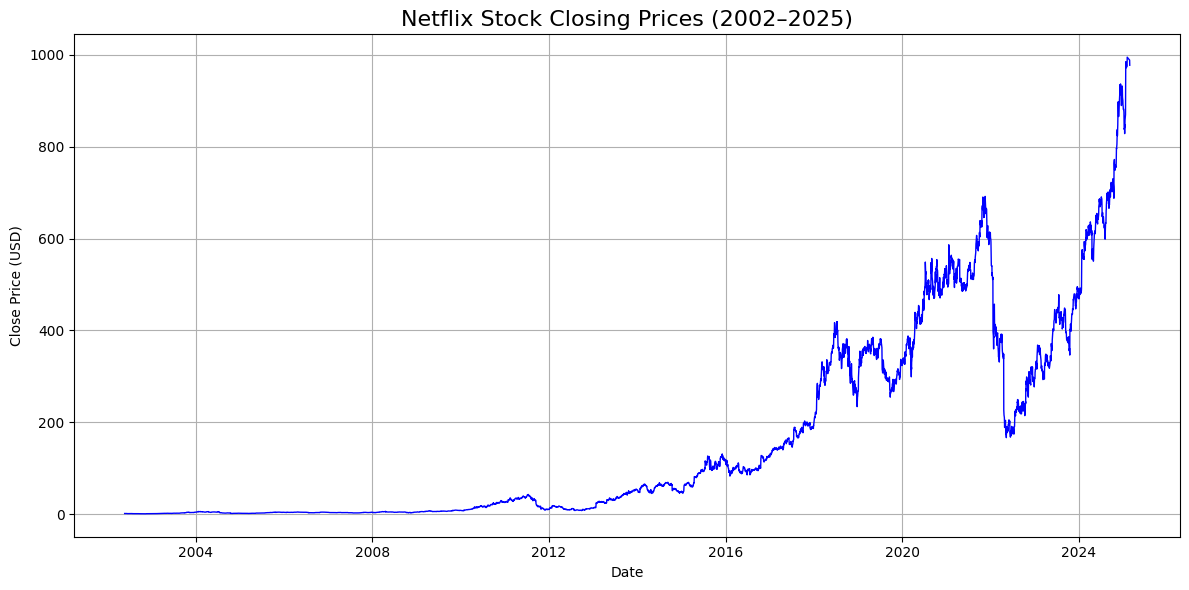

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['Close'], color='blue', linewidth=1)
plt.title("Netflix Stock Closing Prices (2002–2025)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Close Price (USD)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

close_prices = df[['Close']].values

train_size = int(len(df) * 0.8)
train_df = df[:train_size]
test_df = df[train_size:]


scaler = MinMaxScaler()

train_scaled = scaler.fit_transform(train_df[['Close']])
test_scaled = scaler.transform(test_df[['Close']])

print(train_scaled[:2])
print(test_scaled[:2])

print(np.isnan(train_scaled).sum())  # should be 0

print(np.isnan(test_scaled).sum())  # should be 0


[[0.0015136 ]
 [0.00153184]]
[[0.89257057]
 [0.87024947]]
0
0


In [ ]:
import torch

SEQ_len = 30

def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(seq_len, len(data)):
        seq = data[i - seq_len:i]
        target = data[i]

        if not np.isnan(seq).any() and not np.isnan(target).any():
            X.append(seq)
            y.append(target)

    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

X_train, y_train = create_sequences(train_scaled, SEQ_len)
X_test, y_test = create_sequences(test_scaled, SEQ_len)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

X_train, y_train, X_test, y_test = X_train.float(), y_train.float(), X_test.float(), y_test.float()




X_train shape: torch.Size([4542, 30, 1])
y_train shape: torch.Size([4542, 1])


<ipython-input-12-26c58ad1f9f2>:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [ ]:
print(torch.isnan(X_train).sum())  # should be 0
print(torch.isnan(y_train).sum())  # should be 0
print(torch.isnan(X_test).sum())  # should be 0
print(torch.isnan(y_test).sum())  # should be 0


tensor(0)
tensor(0)
tensor(0)
tensor(0)


In [ ]:
## create a dataset class to make it easier to iterate through the data in batches automatically

from torch.utils.data import Dataset

class StockDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]



In [ ]:
from torch.utils.data import DataLoader

train_dataset = StockDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
test_dataset = StockDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

### USING LSTM

LSTM is Long Short Term Memory. this is a recurrent neural network, and is used in problems where the order of the sequence matters. so for stock prices, the past data and the order it is in is important to predict the future price. LSTM basically remembers certain features in the data and decides which of these feautres to send to the next layer, so the model learns based on previous data instead of in isolation.

**An LSTM cell contains three key gates and a memory state:**

* Forget Gate: decides what information to forget from the memory

* Input Gate: decides what new information to add

* Output Gate: decides what part of memory to expose as output

* Cell State: the long-term memory of the LSTM

Every gate uses: weighted sum of inputs (W * x + U * h + b) → sigmoid or tanh









In [ ]:
import torch.nn as nn

class LSTMModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.lstm = nn.LSTM(
        input_size = 1, #just the close price
        hidden_size = 32, #similar to hidden units, i can choose this
        num_layers = 1, #number of stacked LSTM layers
        batch_first = True #this makes input in this format: (batch, seq_len, features)
    )

    self.fc = nn.Linear(in_features=32, out_features=1) #output layer this will map the LSTM output -> predicted stock price

  def forward(self, x):
    lstm_out, _ =  self.lstm(x) #take one batch of data and put it into the LSTM layers, so your output is a (64,30,64) tensor, where 64 is batch, 30 is seq and 64 is hidden_size
    out = lstm_out[:,-1,:] #take the output of the 30th day in the batch(last time step)
    out = self.fc(out) #pass this into the linear layer to get the final prediction
    return out



In [ ]:
model_0 = LSTMModel()


In [ ]:
print(X_train.dtype, y_train.dtype)
print(X_train.min(), X_train.max())  # should be between 0 and 1
print(y_train.min(), y_train.max())  # should also be 0–1 (if scaled)


torch.float32 torch.float32
tensor(0.) tensor(1.)
tensor(0.) tensor(1.)


In [ ]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.005)

In [ ]:
## Train test loop

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_0.to(device)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 50

for epoch in range(epochs):
  model_0.train()
  train_loss = 0

  for X_batch, y_batch in (train_loader):
    X_batch, y_batch = X_batch.to(device).float(), y_batch.to(device).float()

    y_pred = model_0(X_batch)
    loss = loss_fn(y_pred, y_batch)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model_0.parameters(), max_norm=1.0)

    optimizer.step()
    train_loss += loss.item()

  model_0.eval()
  with torch.inference_mode():
    test_loss = 0
    for X_batch, y_batch in test_loader:
      X_batch, y_batch = X_batch.to(device), y_batch.to(device)
      test_pred = model_0(X_batch)
      loss = loss_fn(test_pred, y_batch)
      test_loss += loss.item()

  avg_train_loss = train_loss / len(train_loader)
  avg_test_loss = test_loss / len(test_loader)


  if epoch % 10 == 0:
    print(f"Epoch: {epoch:3} | Train Loss: {avg_train_loss:.6f} | Test Loss: {avg_test_loss:.6f}")




Epoch:   0 | Train Loss: 0.003452 | Test Loss: 0.170537
Epoch:  10 | Train Loss: 0.000524 | Test Loss: 0.030870
Epoch:  20 | Train Loss: 0.000247 | Test Loss: 0.012936
Epoch:  30 | Train Loss: 0.000193 | Test Loss: 0.006696
Epoch:  40 | Train Loss: 0.000791 | Test Loss: 0.003885


In [ ]:
model_0.eval()

with torch.inference_mode():
    X_test = X_test.to(device)
    preds = model_0(X_test).cpu().numpy()
    true = y_test.cpu().numpy()


In [ ]:
# Reshape to 2D since scaler expects that
preds_unscaled = scaler.inverse_transform(preds.reshape(-1, 1))
true_unscaled = scaler.inverse_transform(true.reshape(-1, 1))


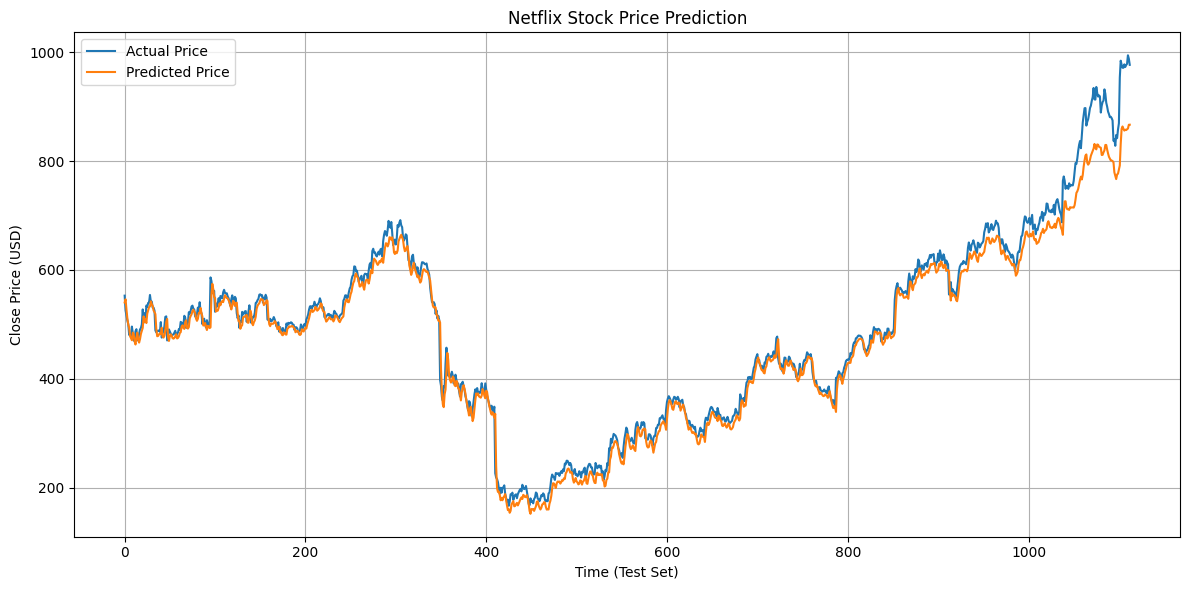

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(true_unscaled, label='Actual Price')
plt.plot(preds_unscaled, label='Predicted Price')
plt.title('Netflix Stock Price Prediction')
plt.xlabel('Time (Test Set)')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from pathlib import Path

MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = 'LSTM_model.pth'
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f'saving model to {MODEL_SAVE_PATH}')

torch.save(obj=model_0.state_dict(), f=MODEL_SAVE_PATH)

saving model to models/LSTM_model.pth


In [ ]:
loaded_model_0 = LSTMModel()
loaded_model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(true_unscaled, preds_unscaled) #mean squared error
rmse = mse**0.5 #root mean squared error
mae = mean_absolute_error(true_unscaled, preds_unscaled) #mean absolute error
r2 = r2_score(true_unscaled, preds_unscaled) #coefficient of determination

print(f'RMSE: ${rmse:.3f}')
print(f'MAE: ${mae:.3f}')
print(f'R2 score: {r2:.3f}')

RMSE: $28.186
MAE: $18.405
R2 score: 0.974


In [ ]:
X_test_np = X_test.cpu().numpy()

ma_preds = np.mean(X_test_np[:, -7:, 0], axis=1)  # 7-day avg
ma_preds = ma_preds.reshape(-1, 1)
ma_preds_unscaled = scaler.inverse_transform(ma_preds)

# Compare metrics
ma_mse = mean_squared_error(true_unscaled, ma_preds_unscaled)
ma_rmse = ma_mse**0.5
print(f"Moving Average RMSE: ${ma_rmse:.2f}")


Moving Average RMSE: $20.96


### Now try doing it with more columns to improve the model.

I am going to use Open, Close, Low, High, and Volume

In [ ]:
from google.colab import files

uploaded = files.upload()


Saving Netflix Inc. (NFLX) Stock Price 2002-2025.csv to Netflix Inc. (NFLX) Stock Price 2002-2025 (1).csv


In [ ]:
import pandas as pd

df2 = pd.read_csv('Netflix Inc. (NFLX) Stock Price 2002-2025.csv')

print(df2.head())
df2.columns = df2.columns.str.strip()
print(df2.columns)

           Date     Open       High       Low     Close Adj Close     Volume
0  Feb 25, 2025     989.4     994.4       955    977.24    977.24  4,733,000
1  Feb 24, 2025  1,008.00  1,015.17    984.48    988.47    988.47  4,426,200
2  Feb 21, 2025  1,029.42  1,032.38    999.39  1,003.15  1,003.15  3,738,700
3  Feb 20, 2025  1,042.00  1,045.00  1,015.59  1,024.54  1,024.54  3,111,800
4  Feb 19, 2025  1,035.18  1,045.00  1,024.51  1,043.33  1,043.33  2,600,000
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [ ]:
df2['Date'] = pd.to_datetime(df2['Date'])

df2 = df2.sort_values('Date').reset_index(drop=True)

data2 = df2[['Open', 'High', 'Low', 'Close', 'Volume']].copy()

data2 = data2.dropna()



print(data2.head())

print(data2.shape)

   Open  High   Low Close       Volume
0  1.16  1.24  1.15   1.2  104,790,000
1  1.21  1.23   1.2  1.21   11,104,800
2  1.21  1.23  1.16  1.16    6,609,400
3  1.16  1.16  1.09   1.1    6,757,800
4  1.11  1.11  1.07  1.07   10,154,200
(5727, 5)


In [ ]:
print(df2['Open'].unique()[:10])
print(df2['Open'].dtype)

# Step 1: Strip all column names just to be safe
df2.columns = df2.columns.str.strip()

# Step 2: Remove commas and dollar signs from string numbers
for col in ['Open', 'High', 'Low', 'Close', 'Volume']:
    df2[col] = df2[col].astype(str).str.replace(',', '').str.replace('$', '').str.strip()


['1.16' '1.21' '1.11' '1.08' '1.14' '1.15' '1.18' '1.13' '1.1' '1.01']
object


In [ ]:
numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
df2[numeric_cols] = df2[numeric_cols].apply(pd.to_numeric, errors='coerce')
df2 = df2.dropna(subset=numeric_cols)

df2.shape



(5727, 7)

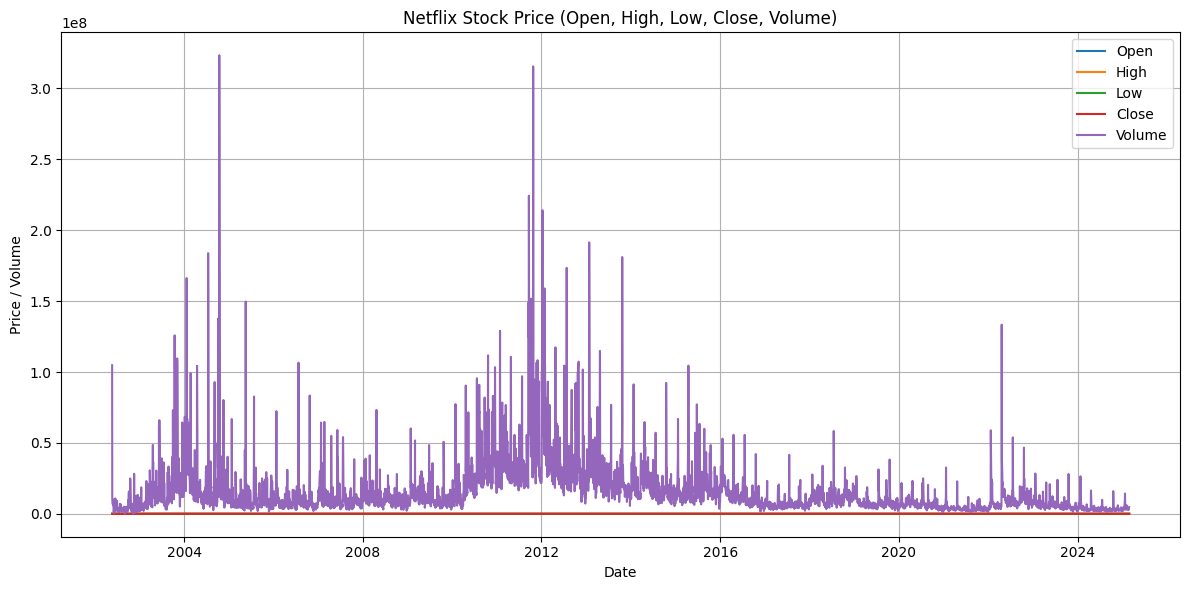

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.plot(df2['Date'], df2['Open'], label='Open')
plt.plot(df2['Date'], df2['High'], label='High')
plt.plot(df2['Date'], df2['Low'], label='Low')
plt.plot(df2['Date'], df2['Close'], label='Close')
plt.plot(df2['Date'], df2['Volume'], label='Volume')  # optional; might be on a different scale

plt.title('Netflix Stock Price (Open, High, Low, Close, Volume)')
plt.xlabel('Date')
plt.ylabel('Price / Volume')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

close_prices = df2[['Close']].values
open_prices = df2[['Open']].values
high_prices = df2[['High']].values
low_prices = df2[['Low']].values
volume = df2[['Volume']].values

train_size = int(len(df2) * 0.8)
train_df = df2[:train_size]
test_df = df2[train_size:]

scaler = MinMaxScaler()

scaler.fit(train_df[['Open', 'High', 'Low', 'Close', 'Volume']])

train_scaled = scaler.transform(train_df[['Open', 'High', 'Low', 'Close', 'Volume']])
test_scaled = scaler.transform(test_df[['Open', 'High', 'Low', 'Close', 'Volume']])

print(train_scaled[:2])
print(test_scaled[:2])

[[0.00137421 0.00144358 0.00153666 0.0015136  0.32341447]
 [0.0014623  0.00142619 0.0016327  0.00153184 0.03348267]]
[[0.87785412 0.8870704  0.95714642 0.92871471 0.01647147]
 [0.89552502 0.88647906 0.96204452 0.91498286 0.01244892]]


In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')


Using device: cuda


In [ ]:
import torch
def create_sequences(data, len_seq):
    X, y = [], []

    for i in range(len_seq, len(data)-4):
        seq = data[i - len_seq:i]
        target = data[i:i+4, 3].mean() #switch to 4 day avg to reduce short term volatility

        if not np.isnan(seq).any() and not np.isnan(target).any():
            X.append(seq)
            y.append(target)

    X = np.array(X)
    y = np.array(y)

    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(1)

SEQ_len = 30
X_train, y_train = create_sequences(train_scaled, SEQ_len)
X_test, y_test = create_sequences(test_scaled, SEQ_len)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')

SEQ_len = 30

X_train shape: torch.Size([4547, 30, 5])
y_train shape: torch.Size([4547, 1])


### make the dataloader class

In [ ]:
from torch.utils.data import Dataset
class StockDataset2(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]


In [ ]:
from torch.utils.data import DataLoader

train_dataset = StockDataset2(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)

test_dataset = StockDataset2(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



In [ ]:
import torch.nn as nn

class LSTMModel2(nn.Module):
  def __init__(self):
    super().__init__()

    self.lstm = nn.LSTM (
        input_size = 5, # 5 cols this time (open, close, high, low, volume)
        hidden_size = 64,
        num_layers = 1,
        batch_first = True)

    self.linear = nn.Linear(in_features=64, out_features=1)

  def forward(self, x):
    lstm_out, _ = self.lstm(x)
    out = lstm_out[:, -1, :]
    out = self.linear(out)
    return out



In [ ]:
model_1 = LSTMModel2()
model_1.to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.002)

In [ ]:
print(train_loader.dataset.X.shape)
print(train_loader.dataset.y.shape)

torch.Size([4547, 30, 5])
torch.Size([4547, 1])


In [ ]:
## Train test loop

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_1.to(device)
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 110

for epoch in range(epochs):
  model_1.train()
  train_loss = 0

  for X_batch, y_batch in (train_loader):
    X_batch, y_batch = X_batch.to(device).float(), y_batch.to(device).float()

    y_pred = model_1(X_batch)
    loss = loss_fn(y_pred, y_batch)

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model_1.parameters(), max_norm=1.0)

    optimizer.step()
    train_loss += loss.item()

  model_1.eval()
  with torch.inference_mode():
    test_loss = 0
    for X_batch, y_batch in test_loader:
      X_batch, y_batch = X_batch.to(device), y_batch.to(device)
      test_pred = model_1(X_batch)
      loss = loss_fn(test_pred, y_batch)
      test_loss += loss.item()

  avg_train_loss = train_loss / len(train_loader)
  avg_test_loss = test_loss / len(test_loader)


  if epoch % 10 == 0:
    print(f"Epoch: {epoch:3} | Train Loss: {avg_train_loss:.6f} | Test Loss: {avg_test_loss:.6f}")

Epoch:   0 | Train Loss: 0.003544 | Test Loss: 0.068029
Epoch:  10 | Train Loss: 0.000802 | Test Loss: 0.005592
Epoch:  20 | Train Loss: 0.000281 | Test Loss: 0.011856
Epoch:  30 | Train Loss: 0.000293 | Test Loss: 0.010836
Epoch:  40 | Train Loss: 0.000381 | Test Loss: 0.008761
Epoch:  50 | Train Loss: 0.001549 | Test Loss: 0.007691
Epoch:  60 | Train Loss: 0.000295 | Test Loss: 0.013483
Epoch:  70 | Train Loss: 0.000175 | Test Loss: 0.006610
Epoch:  80 | Train Loss: 0.000552 | Test Loss: 0.005357
Epoch:  90 | Train Loss: 0.000388 | Test Loss: 0.006087
Epoch: 100 | Train Loss: 0.000798 | Test Loss: 0.004236


In [ ]:
model_1.eval()

with torch.inference_mode():
    X_test = X_test.to(device)
    preds = model_1(X_test).cpu().numpy()
    true = y_test.cpu().numpy()

    # Build dummy arrays with 5 columns to match the scaler
    # We'll insert the predicted close in the correct position (index 3 for 'Close')
    preds_full = np.zeros((len(preds), 5))
    true_full = np.zeros((len(true), 5))

    preds_full[:, 3] = preds.flatten()  # Put predictions in the Close column
    true_full[:, 3] = true.flatten()    # Same for true values

    # Now inverse transform the full array
    preds_unscaled = scaler.inverse_transform(preds_full)[:, 3]  # only keep Close
    true_unscaled = scaler.inverse_transform(true_full)[:, 3]


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

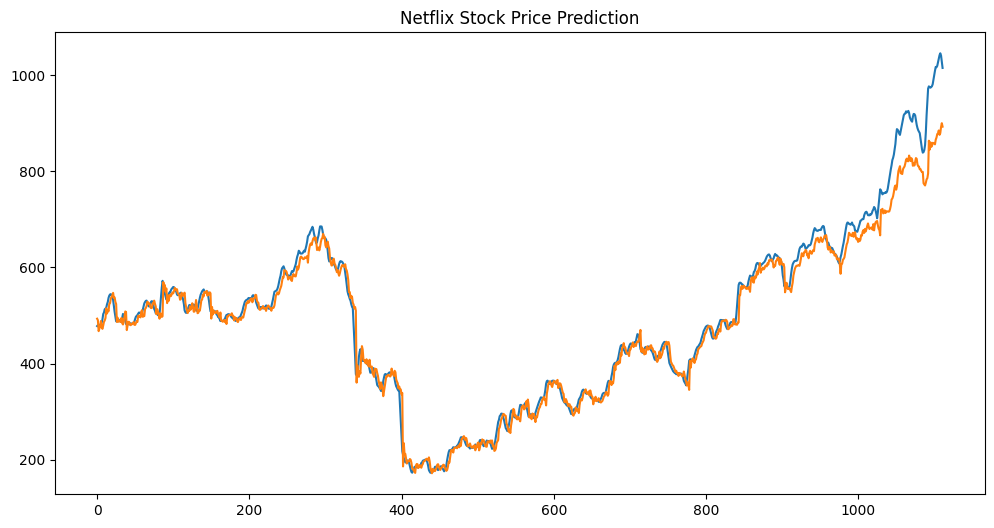

In [ ]:
###now visulaize:

import matplotlib.pyplot as plt

plt.figure(figsize = (12, 6))
plt.plot(true_unscaled, label = 'Actual Price')
plt.plot(preds_unscaled, label = 'Predicted Price')
plt.title('Netflix Stock Price Prediction')
plt

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(true_unscaled, preds_unscaled) #mean squared error
rmse = mse**0.5 #root mean squared error
mae = mean_absolute_error(true_unscaled, preds_unscaled) #mean absolute error
r2 = r2_score(true_unscaled, preds_unscaled) #coefficient of determination

print(f'RMSE: ${rmse:.3f}')
print(f'MAE: ${mae:.3f}')
print(f'R2 score: {r2:.3f}')

RMSE: $32.503
MAE: $18.916
R2 score: 0.968


In [ ]:
# Prepare dummy array for inverse transform
baseline_preds = X_test[:, -1, 3].cpu().numpy()  # last day’s Close in each 30-day input

baseline_full = np.zeros((len(baseline_preds), 5))
baseline_full[:, 3] = baseline_preds  # insert into Close column

baseline_unscaled = scaler.inverse_transform(baseline_full)[:, 3]

baseline_rmse = mean_squared_error(true_unscaled, baseline_unscaled)
baseline_rmse = baseline_rmse**0.5
print(f"Baseline RMSE: ${baseline_rmse:.2f}")


Baseline RMSE: $16.97
